# Beat Tracking

## Imports

In [83]:
import os
import librosa
import librosa.display
import IPython.display as ipd
from matplotlib import pyplot as plt
import numpy as np

from scipy.signal import medfilt as medfilt
from scipy.ndimage import maximum_filter1d as maxfilt

from sklearn.cluster import KMeans

import mir_eval

## Loading file

First applying and demonstrating the pipeline for one file, towards the end will run for a set of files for a generalized evaluation

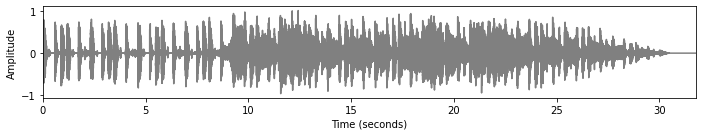

In [2]:
path_data = '../ballroom-data/'

# For now just testing with one
audio_file = path_data+'/Rumba-International/Media-105611.wav'

# Load audio
x, sr = librosa.load(os.path.join(audio_file))  # sampled at a rate of 22050 Hz
ipd.display(ipd.Audio(x,rate=sr))

# Plot audio
t1 = np.arange(x.shape[0]) / sr
plt.figure(figsize=(10, 2))
plt.plot(t1, x, color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t1[0], t1[-1]])
plt.tight_layout()

## Onset Detection

array([2.32199546e-02, 8.82358277e-01, 1.25387755e+00, 2.32199546e+00,
       3.20435374e+00, 3.48299320e+00, 4.71365079e+00, 5.50312925e+00,
       5.78176871e+00, 6.94276644e+00, 7.80190476e+00, 8.10376417e+00,
       9.26476190e+00, 1.04025397e+01, 1.15635374e+01, 1.27245351e+01,
       1.38623129e+01, 1.47214512e+01, 1.50233107e+01, 1.61610884e+01,
       1.70434467e+01, 1.73453061e+01, 1.84830839e+01, 2.08050794e+01,
       2.19428571e+01, 2.31038549e+01, 2.39629932e+01, 2.42416327e+01,
       2.54026304e+01])

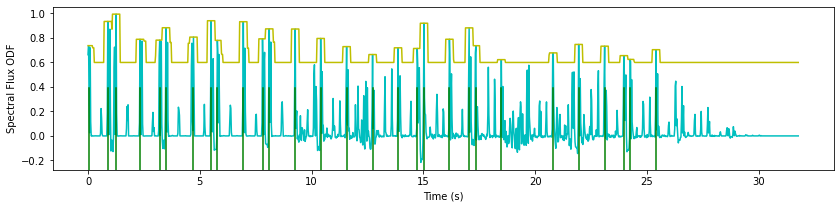

In [60]:
n = 2048
window = 'hann'
hop_length = 512

width = 15
threshold=0.6

def detect_onsets(x, width, threshold):
    # Short Fast Fourier Transform for spectrogram of audio
    D = np.abs(librosa.feature.melspectrogram(x, n_fft=n, window=window, hop_length=hop_length))  # STFT
    D_transp = D.transpose()
    
    # Initialise variables for iterating
    frames = len(D_transp)
    odf = np.zeros(frames)  # stores odf spectral values for insinuating onsets
    bins = len(D)
    prev_magnitude = np.zeros(bins)  # stores magnitude of previous frame
    
    # Iterate through frames, process data via spectral flux
    for i, frame in enumerate(D_transp):
        magnitude = np.abs(frame)
        
        has_greater_magnitude = np.greater(magnitude, prev_magnitude)
        diff_magnitude = np.subtract(magnitude, prev_magnitude)
        
        spectral_flux = np.mean(np.multiply(has_greater_magnitude, diff_magnitude))
        odf[i] = spectral_flux
        
        prev_magnitude = magnitude
        
    # Normalise with respect to maximum odf value
    mx = max(odf)
    if mx > 0: odf /= mx
        
    # Computing peak times by filtering and thresholding
    hop_time = hop_length / sr
    t = np.arange(len(odf)) * hop_time
    odf_med = odf - medfilt(odf, width)
    odf_max = maxfilt(odf_med, width, mode='nearest', axis=0)
    
    thresholds = [max(i, threshold) for i in odf_max]
    peak_args = np.nonzero(np.greater_equal(odf_med, thresholds))
    peak_times = peak_args[0] * hop_time
    
    plt.figure(figsize=(14, 3))
    plt.xlabel('Time (s)')
    plt.ylabel('Spectral Flux ODF')
    plt.plot(t, odf_med, 'c')
    plt.plot(t, thresholds, 'y')
    for p in peak_times:
       plt.axvline(p, ymax=0.5, color='g')
    
    return peak_times
    
onsets = detect_onsets(x, width=width, threshold=threshold)
onsets

## Inter Onset Interval Clustering

1.3477051228654728
23.21995464852608
15.023310657596374
4.54668826260663
8.714117265954


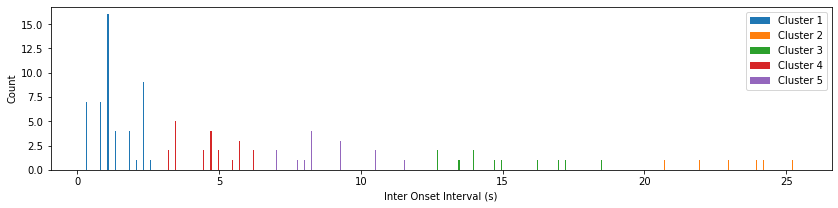

In [145]:
def ioi_clustering(onsets, n_clusters = 5):
    
    # Compute all inter onset intervals
    ioi = []
    for i in range(1, len(onsets)):
        for j in range(i, len(onsets), i):
            ioi.append(onsets[j] - onsets[j-i])

    temp = np.array(ioi).reshape(-1,1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(temp)
    
    # To plot
    n_bins = int(max(ioi) * 10 ** 2)  # Setting a bin per point in 2 d.p. since RT for audio is 0.17s
    
    clusters = [[] for _ in range(n_clusters)]
    for i, label in enumerate(kmeans.labels_):
        clusters[label].append(ioi[i])
    
    plt.figure(figsize=(14, 3))
    hist = plt.hist(clusters, 100)
    plt.legend(['Cluster '+str(i+1) for i in range(n_clusters)])
    plt.xlabel('Inter Onset Interval (s)')
    plt.ylabel('Count')
    
    return clusters
    

ioi_clusters = ioi_clustering(onsets)
for c in clusters:
    print(sum(c)/len(c))


## Periodicity function

In [59]:
def ioi_periodicity(ioi_common):
    tempo = 60 / ioi_common
    samples_per_beat = 60 * (sr/hop_length) / tempo
    return tempo, samples_per_beat

tempo, spb = ioi_periodicity(ioi_common)
tempo
spb

24.965517241379278

## Prediction

In [54]:
def estimate_beats(onsets, arg_start, ioi_common):
    start = onsets[arg_start]
    max_time = len(x) / sr
    estimated_beats = []
    new_beat = 0

    while new_beat < max_time:
        if len(estimated_beats) == 0:
            estimated_beats.append(start)
        else:
            prev = estimated_beats[-1]
            new_beat = prev + ioi_common
            estimated_beats.append(round(new_beat,2))  # rounding to 2 d.p.
            
    return np.array(estimated_beats[:-4])

estimated_beats = estimate_beats(onsets, 0, ioi_common)
estimated_beats

array([2.32199546e-02, 6.00000000e-01, 1.18000000e+00, 1.76000000e+00,
       2.34000000e+00, 2.92000000e+00, 3.50000000e+00, 4.08000000e+00,
       4.66000000e+00, 5.24000000e+00, 5.82000000e+00, 6.40000000e+00,
       6.98000000e+00, 7.56000000e+00, 8.14000000e+00, 8.72000000e+00,
       9.30000000e+00, 9.88000000e+00, 1.04600000e+01, 1.10400000e+01,
       1.16200000e+01, 1.22000000e+01, 1.27800000e+01, 1.33600000e+01,
       1.39400000e+01, 1.45200000e+01, 1.51000000e+01, 1.56800000e+01,
       1.62600000e+01, 1.68400000e+01, 1.74200000e+01, 1.80000000e+01,
       1.85800000e+01, 1.91600000e+01, 1.97400000e+01, 2.03200000e+01,
       2.09000000e+01, 2.14800000e+01, 2.20600000e+01, 2.26400000e+01,
       2.32200000e+01, 2.38000000e+01, 2.43800000e+01, 2.49600000e+01,
       2.55400000e+01, 2.61200000e+01, 2.67000000e+01, 2.72800000e+01,
       2.78600000e+01, 2.84400000e+01, 2.90200000e+01, 2.96000000e+01])

## Results

OrderedDict([('F-measure', 0.2558139534883721),
             ('Cemgil', 0.11037684163106727),
             ('Cemgil Best Metric Level', 0.11037684163106727),
             ('Goto', 0.0),
             ('P-score', 0.627906976744186),
             ('Correct Metric Level Continuous', 0.4186046511627907),
             ('Correct Metric Level Total', 0.4418604651162791),
             ('Any Metric Level Continuous', 0.4186046511627907),
             ('Any Metric Level Total', 0.4418604651162791),
             ('Information gain', 0.4037741145282114)])

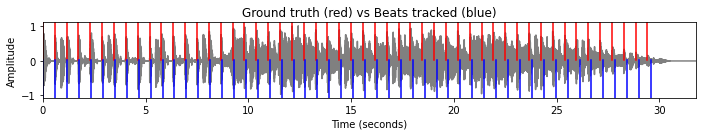

In [55]:
path_data = '../ballroom-annotations/'

# For now just testing with one
annotations_file = path_data+'Media-105611.beats'

def plot_play(true_beats, estimated_beats, x):
    # Audio player
    y = librosa.clicks(times=estimated_beats, sr=sr, length=len(x))
    ipd.display(ipd.Audio(x + y, rate=sr))

    # Plot audio
    t1 = np.arange(x.shape[0]) / sr
    plt.figure(figsize=(10, 2))
    plt.plot(t1, x, color='gray')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.xlim([t1[0], t1[-1]])
    plt.title('Ground truth (red) vs Beats tracked (blue)')
    plt.tight_layout()

    for b in true_beats:
       plt.axvline(b, ymin=0.5, color='r')
    for b in estimated_beats:
       plt.axvline(b, ymax=0.5, color='b')  

    
beat_annotations = np.genfromtxt(annotations_file, delimiter=' ')
true_beats = beat_annotations.transpose()[0]
plot_play(true_beats, estimated_beats, x)
mir_eval.beat.evaluate(true_beats, np.array(estimated_beats))